In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from googletrans import Translator 
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA


df1= pd.read_csv('cleaned_recipe.csv')


df1['title'].nunique()

import re

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation, numbers, and special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize (convert words to their base form)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Join back into a single string
    return " ".join(tokens)

recipes = pd.read_csv("cleaned_recipe.csv")
recipes.dropna(subset=['ingredients', 'instructions'], inplace=True)
recipes['clean_ingredients'] = recipes['ingredients'].apply(preprocess_text)
recipes['clean_instructions'] = recipes['instructions'].apply(preprocess_text)

# Combine them
recipes['combined_features'] = recipes['clean_ingredients'] + " " + recipes['clean_instructions']

from sklearn.feature_extraction.text import TfidfVectorizer
model = TfidfVectorizer(stop_words='english')
model_matrix = model.fit_transform(recipes['combined_features'])
from sklearn.metrics.pairwise import cosine_similarity



In [14]:
# ✅ Step 5: Train a KNN model (unsupervised)
# ----------------------------------------------------
knn = NearestNeighbors(n_neighbors=6, metric='cosine')
knn.fit(model_matrix)

,n_neighbors,6
,radius,1.0
,algorithm,'auto'
,leaf_size,30
,metric,'cosine'
,p,2
,metric_params,None
,n_jobs,None


In [15]:
def recommend_recipe(user_input, top_n=5):
    clean_input = preprocess_text(user_input)
    user_vec = model.transform([clean_input])
    distances, indices = knn.kneighbors(user_vec, n_neighbors=top_n+1)

    results = []
    for dist, idx in zip(distances[0], indices[0]):
        if dist == 0:  # skip self-match
            continue
        results.append({
            "Title": recipes.iloc[idx]['title'],
            "Ingredients": recipes.iloc[idx]['ingredients'],
            "Cuisine": recipes.iloc[idx].get('cuisine', 'Unknown'),
            "Diet": recipes.iloc[idx].get('diet', 'Unknown'),
            "Similarity": round(1 - dist, 3)
        })
    return pd.DataFrame(results[:top_n])

In [16]:
# ✅ Step 7: Test with a sample query
# ----------------------------------------------------
user_query = "potato curry"
recommendations = recommend_recipe(user_query, top_n=5)
print(f"🔍 Recommendations for: '{user_query}'")
recommendations

🔍 Recommendations for: 'potato curry'


,Title,Ingredients,Cuisine,Diet,Similarity
0,Batata Bhaji,"potato,onion,turmeric,mustard seeds,curry leav...",Maharashtrian,vegetarian,0.437
1,Kanda Aloo Sabji,"onion,potato,turmeric,mustard seeds,curry leav...",Maharashtrian,vegetarian,0.270
2,Batata Saar,"potato,tamarind,turmeric,mustard seeds,curry l...",Maharashtrian,vegetarian,0.252
3,Sabudana Khichdi,"sabudana,potato,peanuts,green chili,cumin seed...",Maharashtrian,"vegetarian,fasting",0.200
4,Bhat Bhaaji,"rice,potato,onion,tomato,peas,turmeric,oil,salt",Maharashtrian,vegetarian,0.154


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127858 (\N{POT OF FOOD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


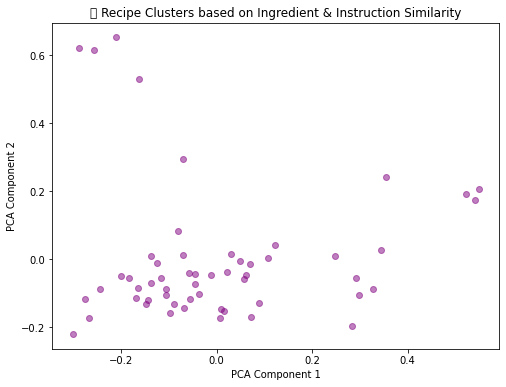

In [18]:
# ✅ Step 8: Visualization – Recipe Clusters using PCA
# ----------------------------------------------------
pca = PCA(n_components=2)
reduced = pca.fit_transform(model_matrix.toarray())

plt.figure(figsize=(8,6))
plt.scatter(reduced[:,0], reduced[:,1], alpha=0.5, c='purple')
plt.title("🍲 Recipe Clusters based on Ingredient & Instruction Similarity")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


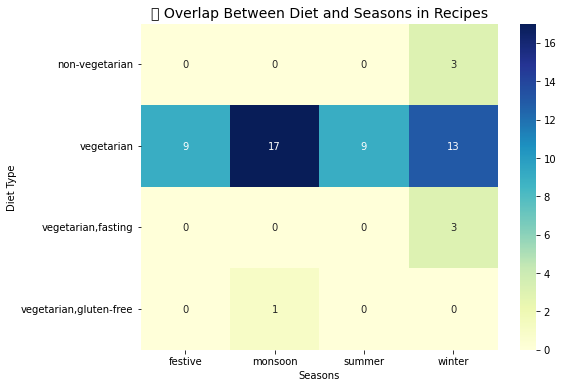

In [20]:
subset = recipes[['diet', 'occasion', 'seasons']].dropna()

# Count unique pairs (for visualization)
cross_table = pd.crosstab(subset['diet'], subset['seasons'])

plt.figure(figsize=(8, 6))
sns.heatmap(cross_table, annot=True, fmt="d", cmap="YlGnBu")
plt.title("🔥 Overlap Between Diet and Seasons in Recipes", fontsize=14)
plt.xlabel("Seasons")
plt.ylabel("Diet Type")
plt.show()

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127869 (\N{FORK AND KNIFE WITH PLATE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


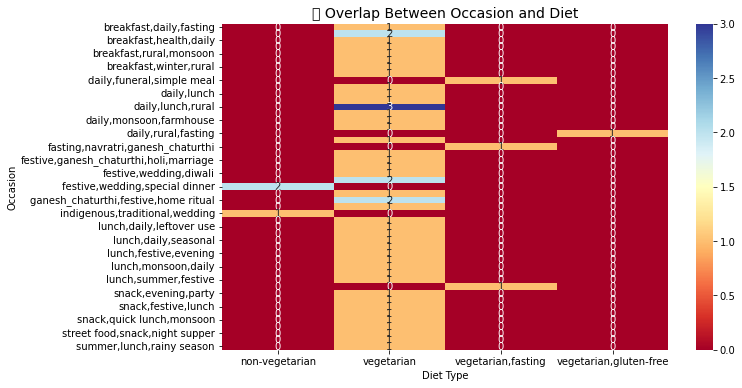

In [21]:
heat_data = pd.crosstab(subset['occasion'], subset['diet'])
plt.figure(figsize=(10, 6))
sns.heatmap(heat_data, annot=True, fmt="d", cmap="RdYlBu")
plt.title("🍽️ Overlap Between Occasion and Diet", fontsize=14)
plt.xlabel("Diet Type")
plt.ylabel("Occasion")
plt.show()